In [51]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  

In [52]:
mnist = input_data.read_data_sets('data/', one_hot=True)
trainimg   = mnist.train.images
trainlabel = mnist.train.labels
testimg    = mnist.test.images
testlabel  = mnist.test.labels

ntrain = trainimg.shape[0] # numbe of training examples

nclass = trainlabel.shape[1] # number of output classes

dim    = trainimg.shape[1] # dimension of input

ntest  = testimg.shape[0] # number of test examples

print ("%d train images loaded" % (ntrain))
print ("%d test images loaded" % (ntest))
print ("%d dimensional input" % (dim))
print ("%d classes" % (nclass))

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/t10k-labels-idx1-ubyte.gz
55000 train images loaded
10000 test images loaded
784 dimensional input
10 classes


In [53]:
# 1. Desing encoders and decoders with convolutional layers
# 1.1.  e.g. 3 ConvLayers (1xn1, n1xn2, n2xn3) for encoders,
# 1.2.  3 ConvLayers (n3xn2, n2xn1, n1x1) for decoders

# define n1, n2 and n3
n1 = 5
n2 = 10
n3 = 15

# input with dimension dim
x = tf.placeholder(tf.float32, [None, dim])

# channel size is 3 for MNIST images
# define weights array
weights = {
    
    # encoding layer
    'wec1': tf.Variable(tf.random_normal([3, 3, 1, n1], stddev=0.1)),
    'wec2': tf.Variable(tf.random_normal([3, 3, n1, n2], stddev=0.1)),
    'wec3': tf.Variable(tf.random_normal([3, 3, n2, n3], stddev=0.1)),
    
    # decoding layer
    'wdc1': tf.Variable(tf.random_normal([3, 3, 1, n1], stddev=0.1)), # n1x1 decode layer
    'wdc2': tf.Variable(tf.random_normal([3, 3, n1, n2], stddev=0.1)), # n2xn1 decode layer
    'wdc3': tf.Variable(tf.random_normal([3, 3, n2, n3], stddev=0.1)) # n3xn2 decode layer
}

# define biases for each of these layer
biases = {
    
    # encoding layer
    'bec1': tf.Variable(tf.random_normal([n1], stddev=0.1)),
    'bec2': tf.Variable(tf.random_normal([n2], stddev=0.1)),
    'bec3': tf.Variable(tf.random_normal([n3], stddev=0.1)),
    
    # decoding layer
    'bdc1': tf.Variable(tf.random_normal([1], stddev=0.1)),
    'bdc2': tf.Variable(tf.random_normal([n1], stddev=0.1)),
    'bdc3': tf.Variable(tf.random_normal([n2], stddev=0.1))
}

# reshape x for convolution
x_reshaped = tf.reshape(x, shape=[-1, 28, 28, 1])
    
# ====== encoder convolutinal layers ======

# apply conv2d
encoder_conv_1 = tf.nn.conv2d(x_reshaped, weights['wec1'], strides=[1, 2, 2, 1], padding='SAME')

# add bias
encoder_conv_1 = tf.add(encoder_conv_1, biases['bec1'])

# apply rely
encoder_conv_1 = tf.nn.relu(encoder_conv_1)
    

# do the same thing for 2nd encoder convolutional layer
encoder_conv_2 = tf.nn.conv2d(encoder_conv_1, weights['wec2'], strides=[1, 2, 2, 1], padding='SAME')
encoder_conv_2 = tf.add(encoder_conv_2, biases['bec2'])
encoder_conv_2 = tf.nn.relu(encoder_conv_2)

# yet again do the same thing 3rd encoder convolutional layer
encoder_conv_3 = tf.nn.conv2d(encoder_conv_2, weights['wec3'], strides=[1, 2, 2, 1], padding='SAME')
encoder_conv_3 = tf.add(encoder_conv_3, biases['bec3']) 
encoder_conv_3 = tf.nn.relu(encoder_conv_3) 


# ====== decoder convolutinal layers ======

# 2. You may need to use tf.pack to make a output_shape of tf.nn.conv2d_transpose for decoders

# do the same process in reverse order as compared to decoder. n2xn3 = n3xn2, n1xn2 = n2xn1, and 1xn1 = n1x1
decoder_conv_3 = tf.nn.conv2d_transpose(encoder_conv_3, weights['wdc3'], 
                        tf.pack([tf.shape(x)[0], 7, 7, n2]), 
                        strides=[1, 2, 2, 1], padding='SAME')
decoder_conv_3 = tf.add(decoder_conv_3, biases['bdc3'])
decoder_conv_3 = tf.nn.relu(decoder_conv_3)
    

# now the 2nd decoder convolutional layer
decoder_conv_2 = tf.nn.conv2d_transpose(decoder_conv_3, weights['wdc2'], 
                                        tf.pack([tf.shape(x)[0], 14, 14, n1]), 
                                        strides=[1, 2, 2, 1], padding='SAME')
decoder_conv_2 = tf.add(decoder_conv_2 , biases['bdc2'])
decoder_conv_2 = tf.nn.relu(decoder_conv_2) 

# at last the 3rd decoder convolutional layer
decoder_conv_1 = tf.nn.conv2d_transpose(decoder_conv_2, weights['wdc1'], 
                                        tf.pack([tf.shape(x)[0], 28, 28, 1]),
                                        strides=[1, 2, 2, 1], padding='SAME')
decoder_conv_1 = tf.add(decoder_conv_1, biases['bdc1'])
out = tf.nn.relu(decoder_conv_1)

In [56]:
# Parameters
learning_rate   = 0.001
training_epochs = 10
batch_size      = 100
display_step    = 1

# Saver 
save_step = 10
saver = tf.train.Saver(max_to_keep=training_epochs)

# 3. • with a MSE cost function to minimize L(x, g(f(x)))

cost = tf.reduce_sum(tf.square(x_reshaped - out)) # squared error function
optm = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# init all variables
init = tf.initialize_all_variables()

# Launch the graph
sess = tf.Session()
sess.run(init)

# as presented in assignment6 pdf file
mean_image = np.mean(mnist.train.images, axis=0)
                     
# Training cycle
for epoch in range(training_epochs):
    avg_cost = 0.
    num_batch = int(ntrain / batch_size) + 1
    # Loop over all batches
    for i in range(num_batch): 
        batch_xs, _ = mnist.train.next_batch(batch_size)
        train = np.array([image - mean_image for image in batch_xs])
        sess.run(optm, feed_dict={x: train})
                     
        # Compute average loss
        avg_cost += sess.run(cost, feed_dict={x: train}) / num_batch

    # Display log per epoch step
    if epoch % display_step == 0:
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
            
    # Save Net
    #if epoch % save_step == 0:
        #saver.save(sess, "nets/cnn_encoder_decoder.ckpt-" + str(epoch))

print ("Optimization Finished!")

Epoch: 000/010 cost: 3083.794134510
Epoch: 001/010 cost: 2197.603271041
Epoch: 002/010 cost: 2099.262961386
Epoch: 003/010 cost: 2046.555615101
Epoch: 004/010 cost: 2017.706087697
Epoch: 005/010 cost: 2000.053859371
Epoch: 006/010 cost: 1988.797969423
Epoch: 007/010 cost: 1980.747574766
Epoch: 008/010 cost: 1974.078910149
Epoch: 009/010 cost: 1968.910519581
Optimization Finished!


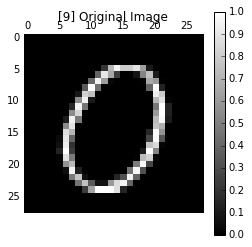

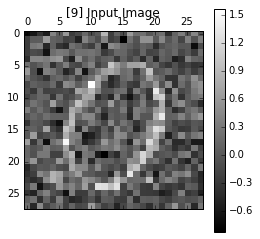

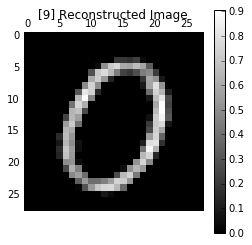

In [57]:
# 4. • Reconstruct images from corrupted images with Gaussian noise

# Test one
randidx  = np.random.randint(testimg.shape[0], size=1)
testvec  = testimg[randidx, :]
noisyvec = testvec + 0.3 * np.random.randn(1, 784)
outvec   = sess.run(out, feed_dict={x: testvec})
outimg   = np.reshape(outvec, (28, 28))

# Plot 
plt.matshow(np.reshape(testvec, (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("[" + str(epoch) + "] Original Image")
plt.colorbar()

plt.matshow(np.reshape(noisyvec, (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("[" + str(epoch) + "] Input Image")
plt.colorbar()

plt.matshow(outimg, cmap=plt.get_cmap('gray'))
plt.title("[" + str(epoch) + "] Reconstructed Image")
plt.colorbar()
plt.show()

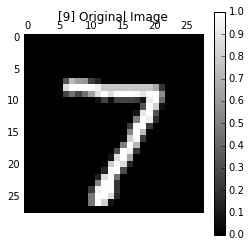

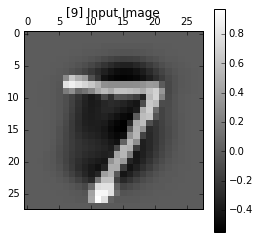

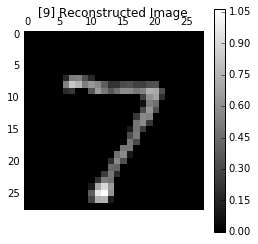

In [58]:
# 4. • Reconstruct images from corrumpted images by normalization

# Test one, as was in assignment6 pdf file
test_xs, _ = mnist.test.next_batch(1)
test_xs_norm = np.array([image - mean_image for image in test_xs])

outvec   = sess.run(out, feed_dict={x: test_xs_norm})
outimg   = np.reshape(outvec, (28, 28))

# Plot 
plt.matshow(np.reshape(test_xs, (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("[" + str(epoch) + "] Original Image")
plt.colorbar()

plt.matshow(np.reshape(test_xs_norm, (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("[" + str(epoch) + "] Input Image")
plt.colorbar()

plt.matshow(outimg, cmap=plt.get_cmap('gray'))
plt.title("[" + str(epoch) + "] Reconstructed Image")
plt.colorbar()
plt.show()